
# Previsão de Temperatura com Modelos de Deep Learning

Este projeto visa prever a temperatura horária (°C) com 24 horas de antecedência utilizando dados meteorológicos da estação Jena, Alemanha, no período de 2009 a 2016.

Como se trata de um problema sequence-to-sequence, os modelos inicialmente considerados foram LSTM, GRU, RNN e Transformer, por sua capacidade de capturar dependências temporais em séries temporais. No entanto, devido à limitação de tempo para implementação, optou-se por deixar os Transformers de fora nesta etapa.

A modelagem final considera duas arquiteturas principais: LSTM e GRU, avaliadas em relação ao erro absoluto médio (MAE).

## 1. Importação de Bibliotecas

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense


2025-08-05 17:56:43.939269: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 17:56:43.949788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754427403.961650   25469 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754427403.965139   25469 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754427403.974571   25469 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 2. Carregamento e Análise Exploratória dos Dados

In [2]:

df = pd.read_csv("jena_climate_2009_2016.csv")
df["Date Time"] = pd.to_datetime(df["Date Time"], dayfirst=True)
df = df.set_index("Date Time")

df.shape, df.columns


((420551, 14),
 Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
        'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)'],
       dtype='object'))

### 2.1. Análise Exploratória dos Dados

In [3]:
print("Time range:", df.index.min(), "→", df.index.max())

Time range: 2009-01-01 00:10:00 → 2017-01-01 00:00:00


In [4]:
df.isnull().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

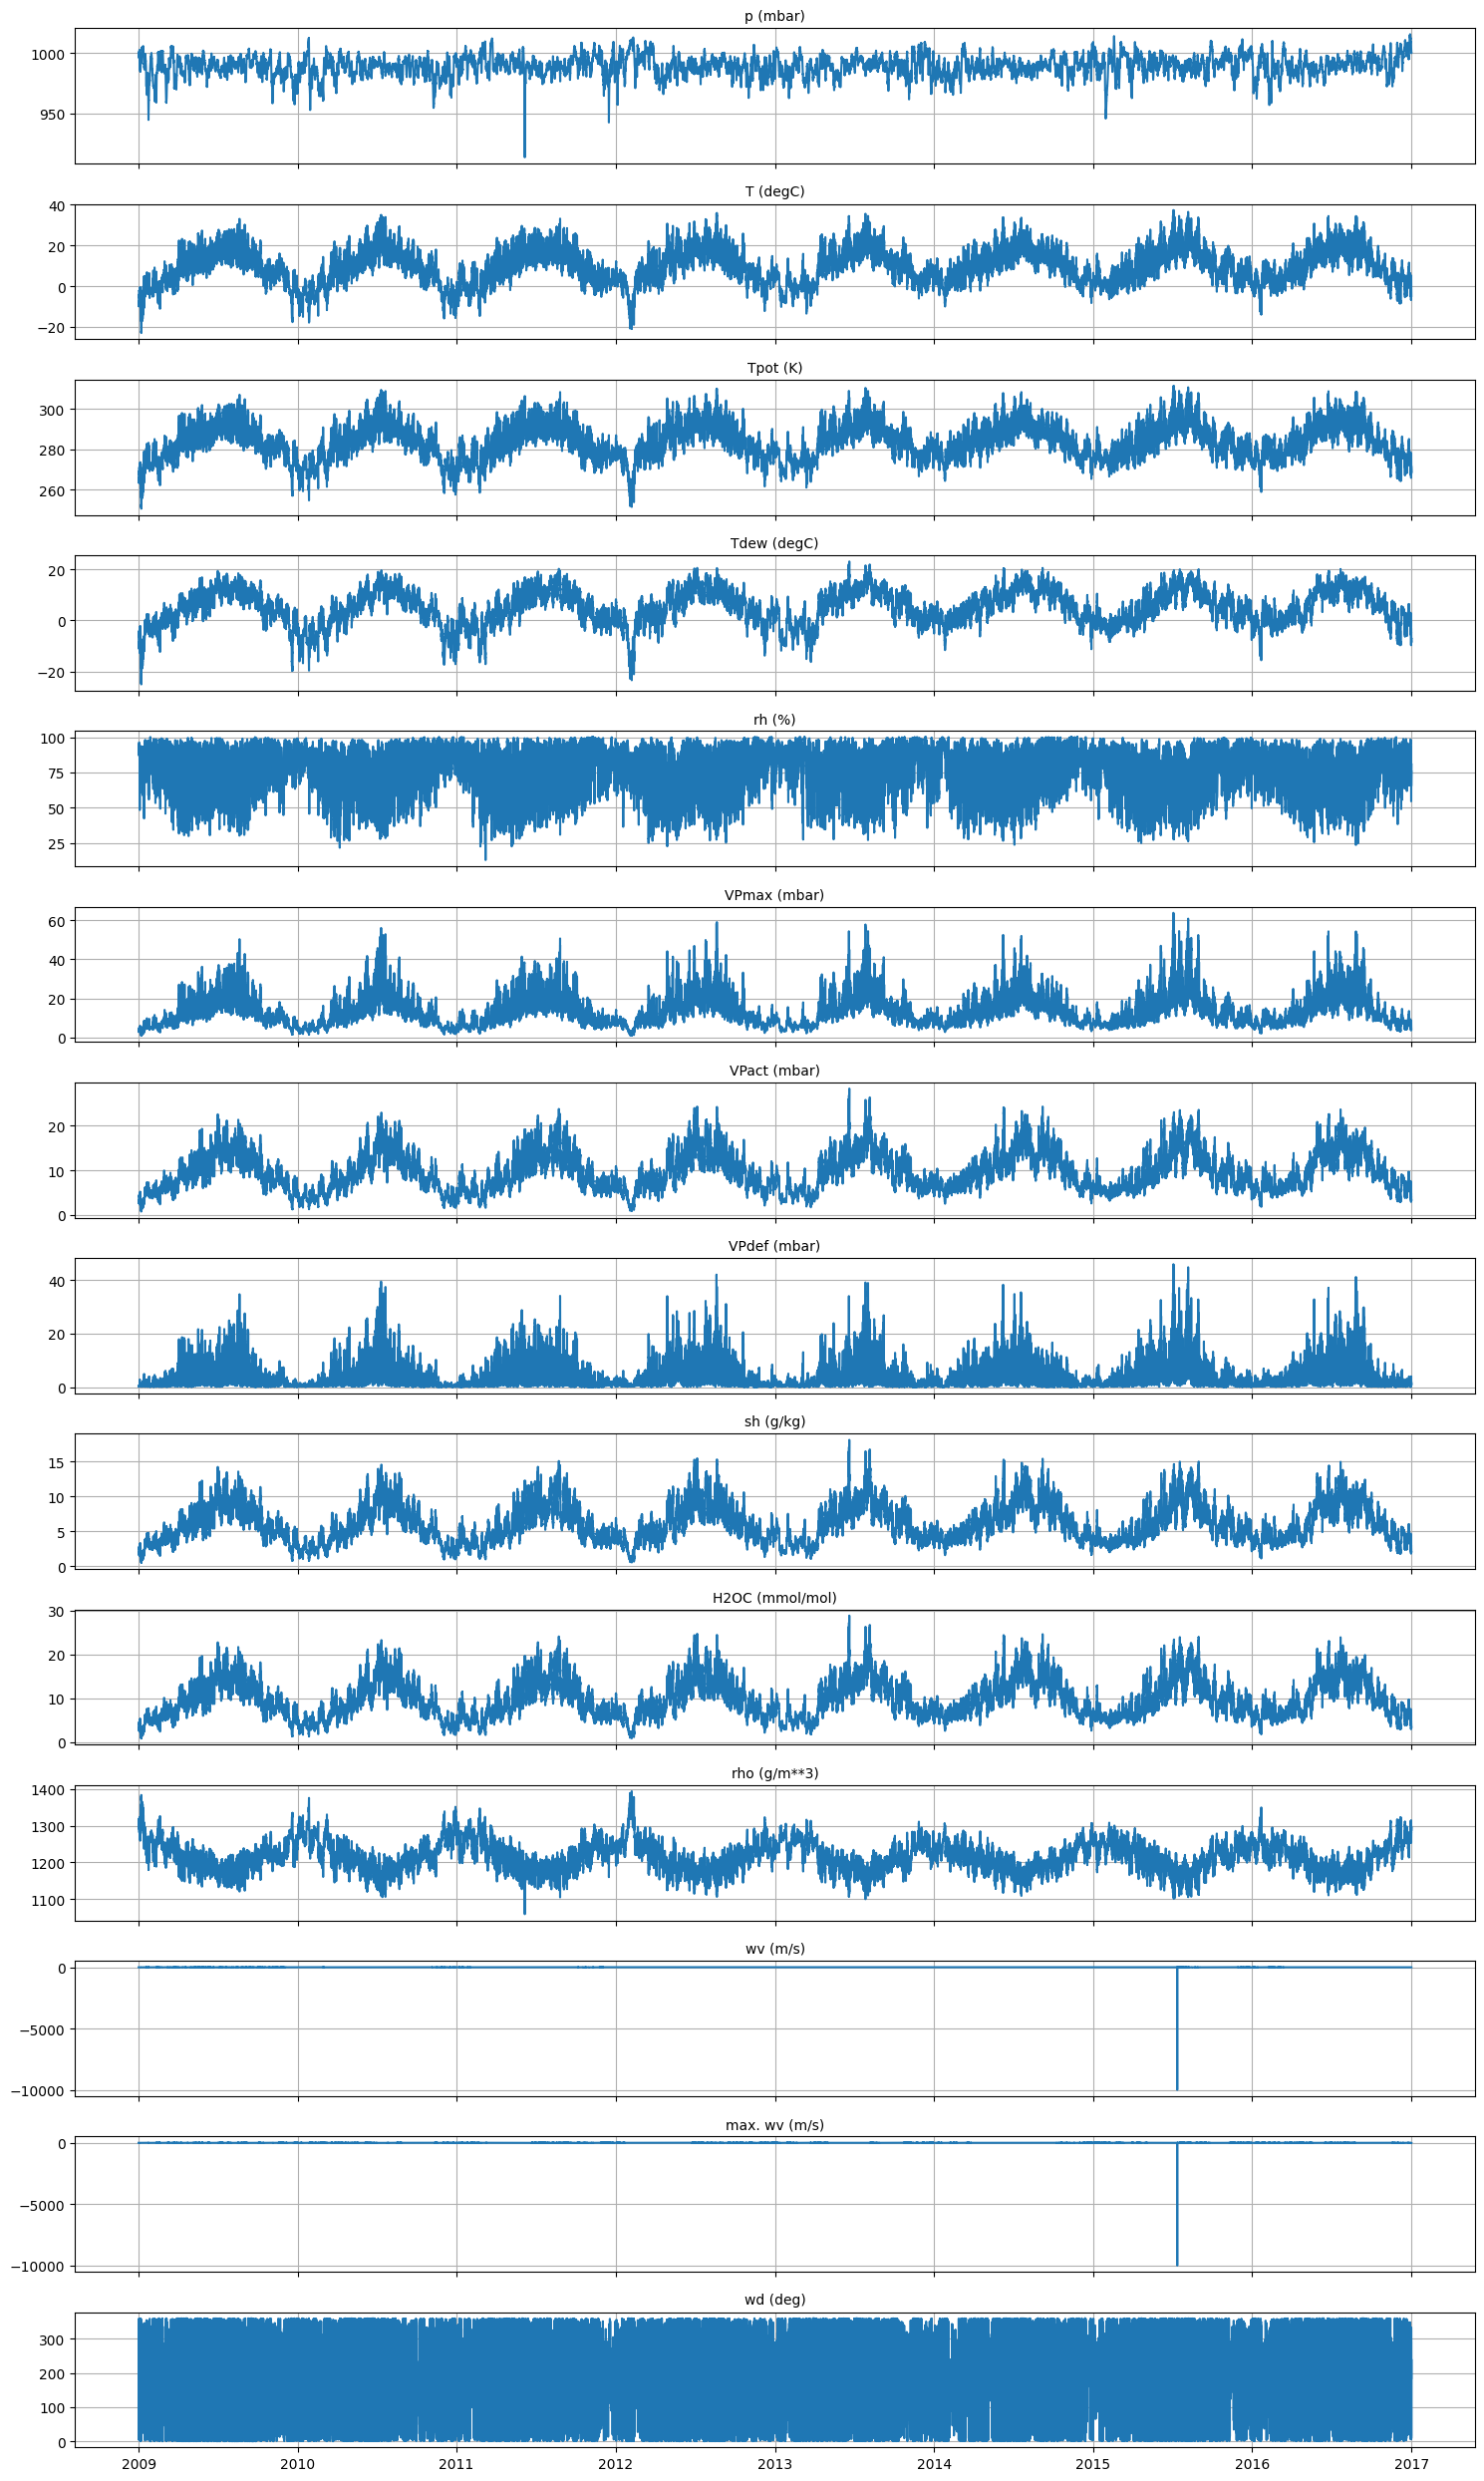

In [5]:
fig, axes = plt.subplots(nrows=14, ncols=1, figsize=(15, 25), sharex=True)

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col])
    axes[i].set_title(col, fontsize=10)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

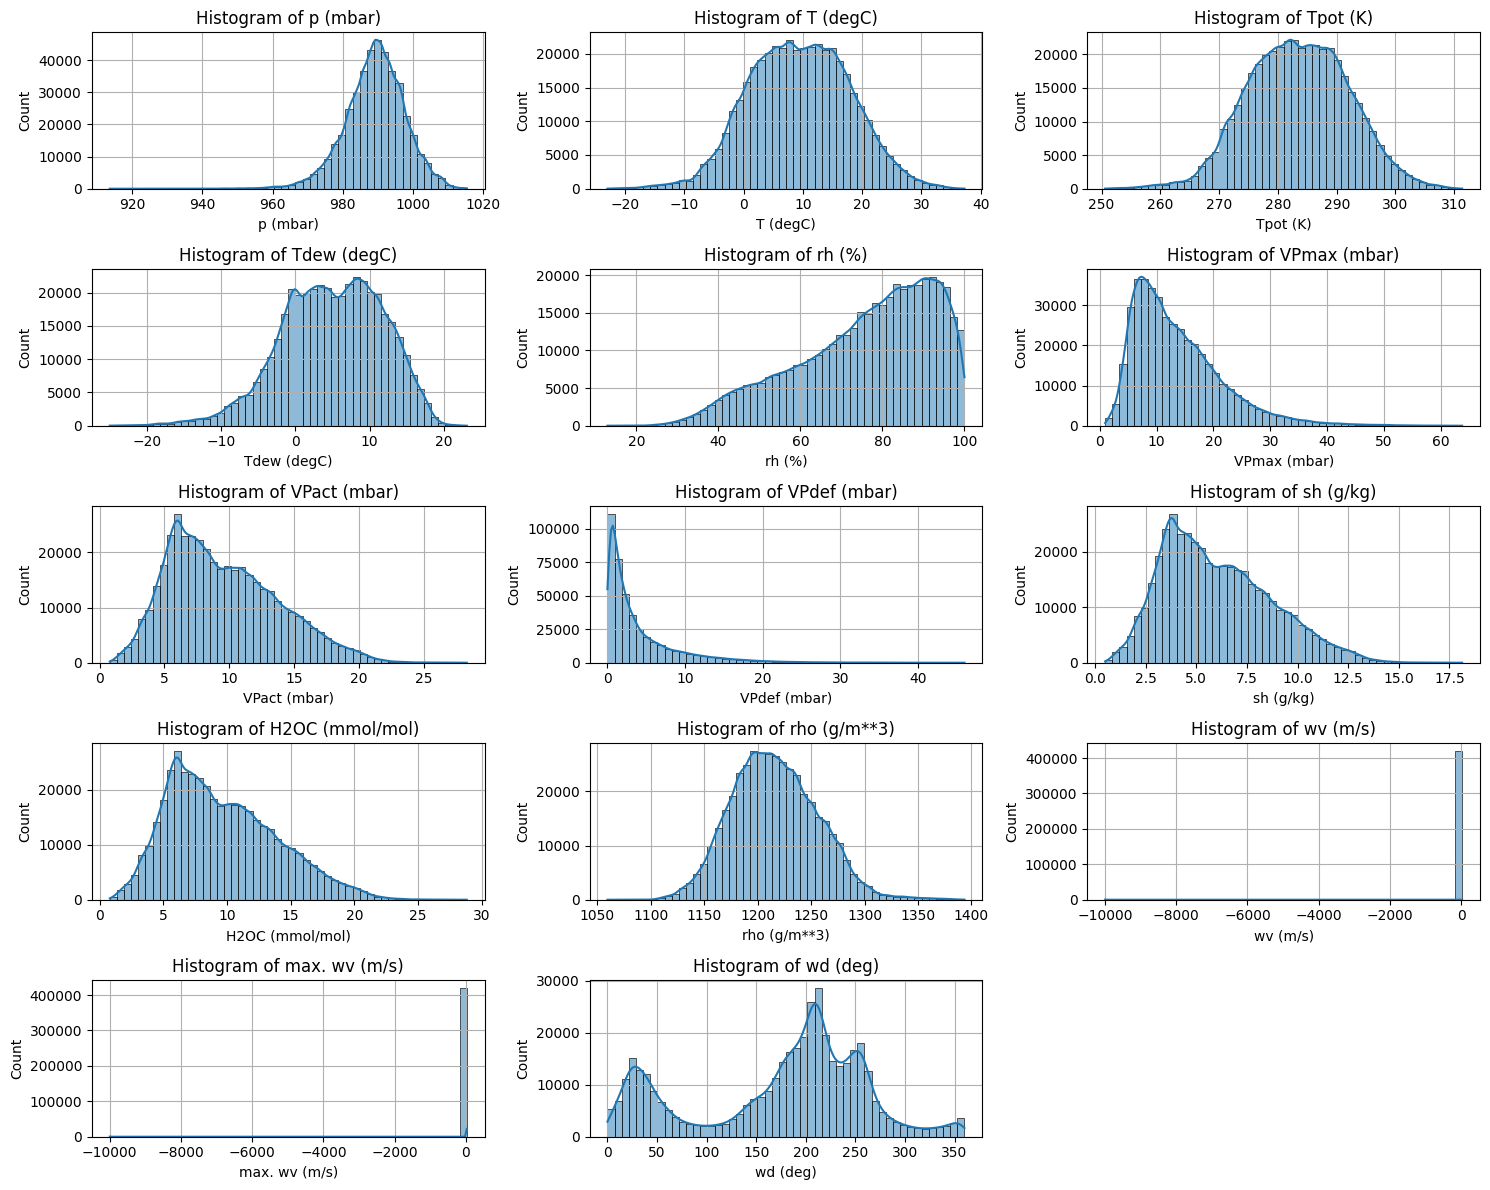

In [6]:
# Número de colunas
n_cols = 3
n_rows = int(len(df.columns) / n_cols) + 1

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, bins=50)
    axes[i].set_title(f'Histogram of {col}')
    axes[i].grid(True)

# Remove subplots vazios se houver
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 2.3. Análise de Outliers
Ao analisar os dados, é possível identificar claramente a presença de outliers nas variáveis wv (m/s) e max. wv (m/s). Para tratar essas anomalias, será aplicado o método da distância interquartílica (IQR - Interquartile Range), que é uma técnica robusta e amplamente utilizada para a detecção e remoção de valores extremos em distribuições numéricas.

In [7]:
Q1 = df['wv (m/s)'].quantile(0.25)
Q3 = df['wv (m/s)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out values outside the bounds
df = df[(df['wv (m/s)'] >= lower_bound) & (df['wv (m/s)'] <= upper_bound)]

In [8]:
Q1 = df['max. wv (m/s)'].quantile(0.25)
Q3 = df['max. wv (m/s)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out values outside the bounds
df = df[(df['max. wv (m/s)'] >= lower_bound) & (df['max. wv (m/s)'] <= upper_bound)]

In [9]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000,418677.000000
mean,989.255873,9.446849,283.485880,4.960380,76.051559,13.577682,9.538673,4.038925,6.025314,9.644844,1216.130668,2.098372,3.486459,174.585513
std,8.329861,8.433743,8.514661,6.739321,16.484158,7.748206,4.189270,4.902101,2.659428,4.240637,40.014346,1.466810,2.238822,86.824990
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.250000,3.340000,277.410000,0.230000,65.250000,7.760000,6.210000,0.870000,3.920000,6.280000,1187.510000,0.990000,1.760000,123.900000
50%,989.600000,9.420000,283.460000,5.230000,79.400000,11.820000,8.870000,2.170000,5.600000,8.970000,1213.850000,1.750000,2.960000,197.800000
75%,994.750000,15.480000,289.540000,10.090000,89.500000,17.610000,12.360000,5.300000,7.810000,12.500000,1242.910000,2.840000,4.720000,234.300000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,8.460000,13.590000,360.000000


### 2.2. Seleção de Features e Frequência Temporal
O objetivo deste projeto é realizar previsões horárias da temperatura para as próximas 24 horas. Por esse motivo, optei por reamostrar os dados para uma frequência temporal de 1 hora, garantindo que o modelo receba informações compatíveis com a escala de tempo das previsões desejadas.

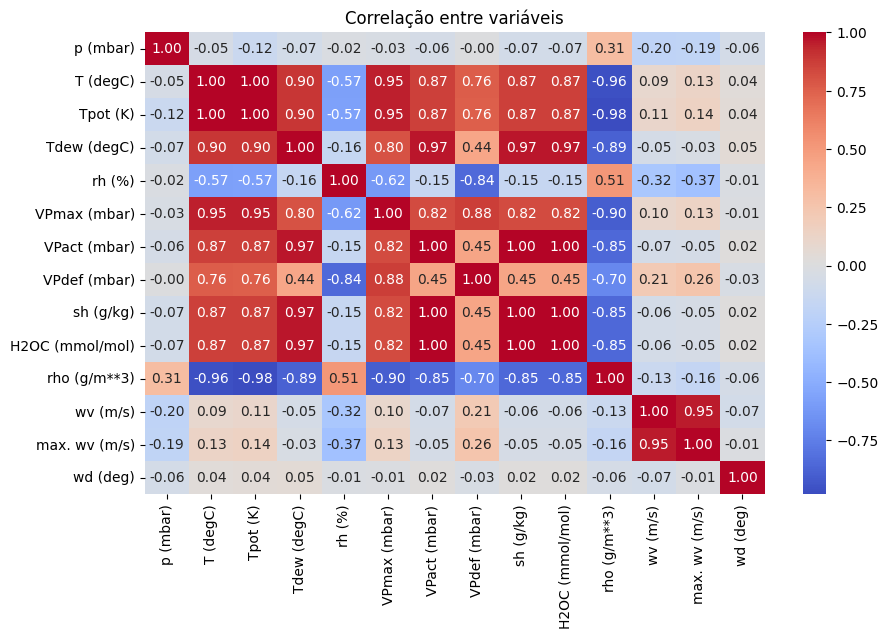

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre variáveis")
plt.show()

VPact, sh, and H2OC - Essas três são perfeitamento correlacionadas entre si, logo vou escolher apenas uma para não haver redundancia.

p (mbar), wv e max. wv - correlação muito fraca com a temperatura


In [11]:

features = ['rh (%)', 'VPmax (mbar)', 'VPdef (mbar)', 
            'sh (g/kg)', 'rho (g/m**3)']
target = 'T (degC)'

# Checagem de frequências
freqs = df.index.to_series().diff().value_counts().head()
print("Top time deltas:\n", freqs)

# Resample para 1h se necessário
df = df[features + [target]].resample('1H').mean().interpolate()


Top time deltas:
 Date Time
0 days 00:10:00    418023
0 days 00:20:00       335
0 days 00:30:00       133
0 days 00:40:00        51
0 days 00:50:00        35
Name: count, dtype: int64


/tmp/ipykernel_25469/2197026394.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df[features + [target]].resample('1H').mean().interpolate()


## 3. Preparação de Dados para Modelagem

In [12]:
def add_seasonal_features(df):
    df_copy = df.copy()

    months = df_copy.index.month
    
    df_copy['spring'] = (months.isin([3, 4, 5])).astype(int)
    df_copy['summer'] = (months.isin([6, 7, 8])).astype(int)
    df_copy['autumn'] = (months.isin([9, 10, 11])).astype(int)
    df_copy['winter'] = (months.isin([12, 1, 2])).astype(int)
    
    return df_copy

features.extend(['spring', 'summer', 'autumn', 'winter'])
df_with_seasons = add_seasonal_features(df)

In [13]:
# utilizando stardard scaler pois a maioria dos dados se parece com uma distribuição normal
scaler = StandardScaler()
scaled = scaler.fit_transform(df_with_seasons)
scaled_df = pd.DataFrame(scaled, index=df_with_seasons.index, columns=df_with_seasons.columns)

input_width = 336 # ultimos 14 dias vão prever as proximas 24 horas
label_width = 24

def create_sequences(df, features, target, input_width, label_width):
    X, y = [], []
    
    feature_data = df[features].values
    target_data = df[target].values
    
    for i in range(len(df) - input_width - label_width):
        X.append(feature_data[i:i+input_width])
        y.append(target_data[i+input_width:i+input_width+label_width])
    
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_df, features, target, input_width, label_width)

train_size = int(0.7 * len(X_seq))
val_size = int(0.2 * len(X_seq))
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size+val_size], y_seq[train_size:train_size+val_size]
X_test, y_test = X_seq[train_size+val_size:], y_seq[train_size+val_size:]


In [23]:
X_seq.shape

(69769, 336, 9)

In [25]:
y_seq.shape

(69769, 24)

## 4. Modelagem e Avaliação

### 4.1 LSTM

In [14]:

model_lstm = Sequential([
    LSTM(64, return_sequences=False, input_shape=(input_width, len(features))),
    Dense(64, activation='relu'),
    Dense(label_width)
])

# Mean Absolute Error como loss function pois é como o modelo será avaliado, quero minimizar essa função
model_lstm.compile(optimizer='adam', loss='mae')
# Shuffle = False pois se trata de uma série temporal
history_lstm = model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, shuffle=False)


I0000 00:00:1754427429.660467   25469 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1564 MB memory:  -> device: 0, name: NVIDIA GeForce MX570 A, pci bus id: 0000:02:00.0, compute capability: 8.6
/home/xavier/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1754427432.456251   25557 cuda_dnn.cc:529] Loaded cuDNN version 90300


1527/1527 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.3486 - val_loss: 0.3243
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.2810 - val_loss: 0.2987
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.2668 - val_loss: 0.2835
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.2581 - val_loss: 0.2719
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2535 - val_loss: 0.2647
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2478 - val_loss: 0.2659
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.2464 - val_loss: 0.2566
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2411 - val_loss: 0.2478
Epoch 9/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2378 - val_loss: 0.2479
Epoch 10/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.2354 - val_loss: 0.2444


### 4.2 GRU

In [15]:
model_gru = Sequential([
    GRU(64, return_sequences=False, input_shape=(input_width, len(features))),
    Dense(64, activation='relu'),
    Dense(label_width)
])

# Mean Absolute Error como loss function pois é como o modelo será avaliado, quero minimizar essa função
model_gru.compile(optimizer='adam', loss='mae')
# Shuffle = False pois se trata de uma série temporal
history_gru = model_gru.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, shuffle=False)

Epoch 1/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - loss: 0.3451 - val_loss: 0.2976
Epoch 2/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2748 - val_loss: 0.2795
Epoch 3/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2619 - val_loss: 0.2690
Epoch 4/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2549 - val_loss: 0.2598
Epoch 5/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2490 - val_loss: 0.2588
Epoch 6/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2450 - val_loss: 0.2569
Epoch 7/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.2420 - val_loss: 0.2525
Epoch 8/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - loss: 0.2387 - val_loss: 0.2500
Epoch 9/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.2363 - val_loss: 0.2513
Epoch 10/10
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - loss: 0.2342 - val_loss: 0.2523


## 5. Avaliação no Conjunto de Teste

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


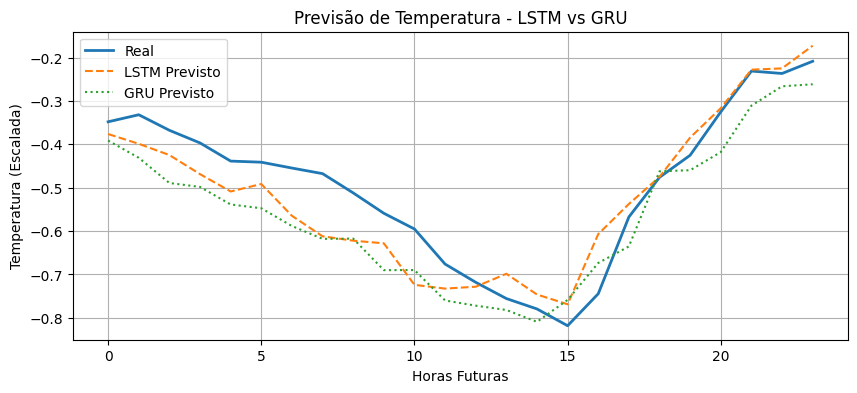

MAE LSTM: 0.2147
MAE GRU: 0.2246


In [16]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

sample_idx = 200

# Exemplo de ua amostra do conjunto teste
plt.figure(figsize=(10, 4))
plt.plot(y_test[sample_idx], label='Real', linewidth=2)
plt.plot(y_pred_lstm[sample_idx], label='LSTM Previsto', linestyle='--')
plt.plot(y_pred_gru[sample_idx], label='GRU Previsto', linestyle=':')
plt.title("Previsão de Temperatura - LSTM vs GRU")
plt.xlabel("Horas Futuras")
plt.ylabel("Temperatura (Escalada)")
plt.legend()
plt.grid(True)
plt.show()

# Calcular MAE no conjunto teste
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mae_gru = mean_absolute_error(y_test, y_pred_gru)

print(f"MAE LSTM: {mae_lstm:.4f}")
print(f"MAE GRU: {mae_gru:.4f}")

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


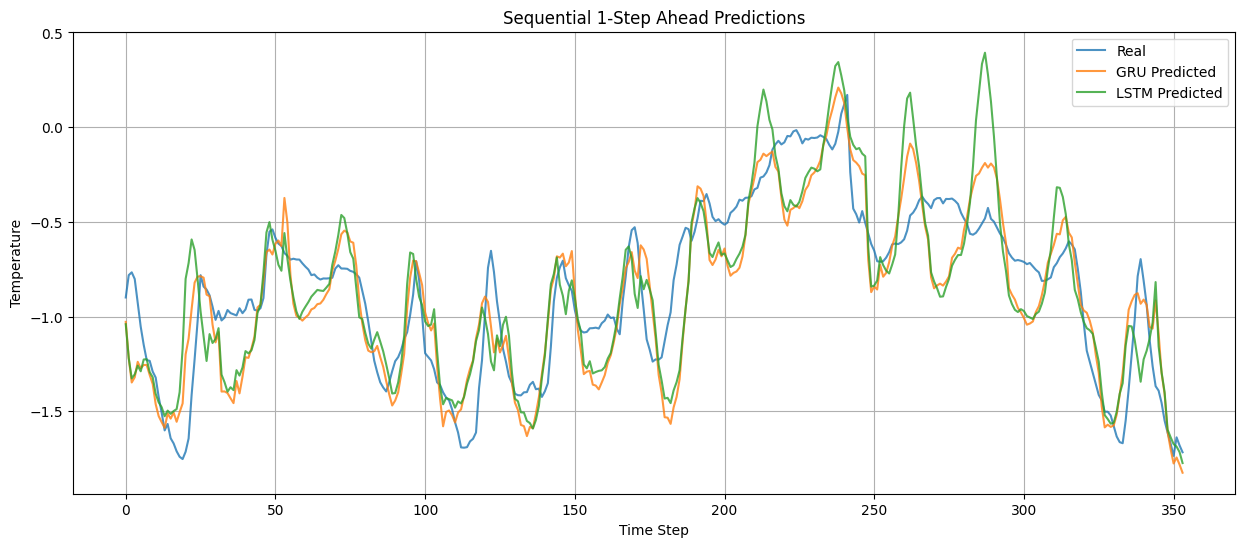

MAE LSTM: 0.1880
MAE GRU: 0.2008


In [30]:
y_test_seq = y_test[:, 5]

y_pred_esc_gru = model_gru.predict(X_test)
y_pred_esc_lstm = model_lstm.predict(X_test)

y_pred_seq_gru = y_pred_esc_gru[:, 5]
y_pred_seq_lstm = y_pred_esc_lstm[:, 5]

plt.figure(figsize=(15, 6))
plt.plot(y_test_seq[-354:], label='Real', alpha=0.8)
plt.plot(y_pred_seq_gru[-354:], label='GRU Predicted', alpha=0.8)
plt.plot(y_pred_seq_lstm[-354:], label='LSTM Predicted', alpha=0.8)
plt.title(f"Sequential {1}-Step Ahead Predictions")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

mae_lstm = mean_absolute_error(y_test_seq, y_pred_seq_lstm)
mae_gru = mean_absolute_error(y_test_seq, y_pred_seq_gru)

print(f"MAE LSTM: {mae_lstm:.4f}")
print(f"MAE GRU: {mae_gru:.4f}")

### 5.1. Análise de Resíduos

219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


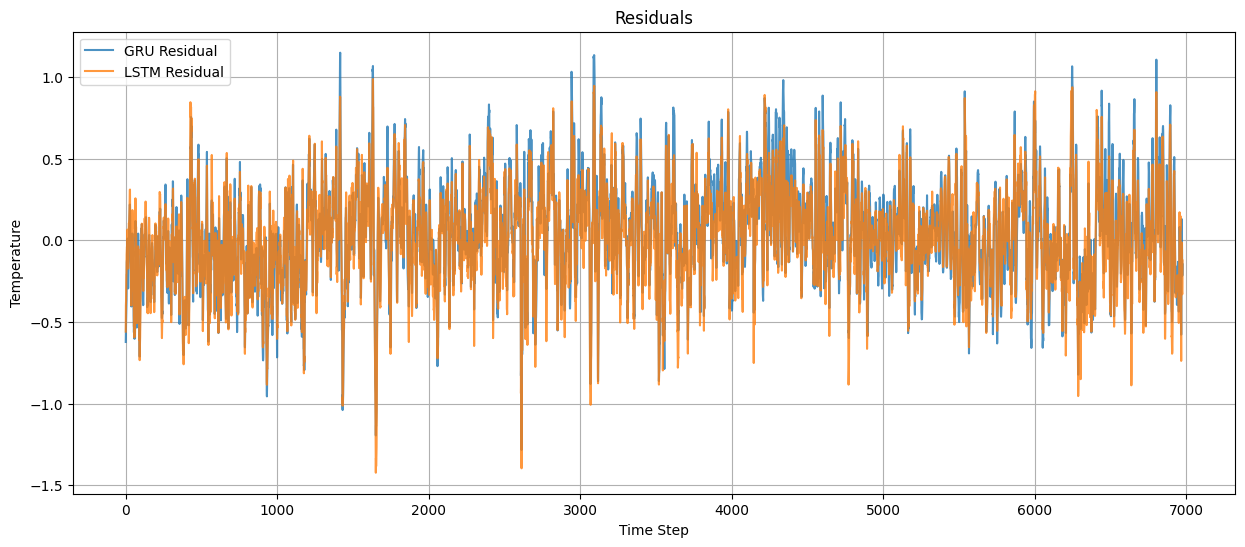

In [31]:
y_test_seq = y_test[:, 11]

y_pred_esc_gru = model_gru.predict(X_test)
y_pred_esc_lstm = model_lstm.predict(X_test)

y_pred_seq_gru = y_pred_esc_gru[:, 11]
y_pred_seq_lstm = y_pred_esc_lstm[:, 11]

gru_residuals = y_test_seq - y_pred_esc_gru[:, 11]
lstm_residuals = y_test_seq - y_pred_esc_lstm[:, 11]

plt.figure(figsize=(15, 6))
plt.plot(gru_residuals, label='GRU Residual', alpha=0.8)
plt.plot(lstm_residuals, label='LSTM Residual', alpha=0.8)
plt.title(f"Residuals")
plt.xlabel("Time Step")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()

- Resíduos oscilam em torno de zero.
- Não seguem um padrão

Até em tão tudo certo com a regressão

In [32]:
print(f"Média dos resíduos GRU: {gru_residuals.mean():.4f}")
print(f"Média dos resíduos LSTM: {lstm_residuals.mean():.4f}")


Média dos resíduos GRU: 0.0407
Média dos resíduos LSTM: 0.0095


Média dos residuos dos dois modelos igual a zero como esperado

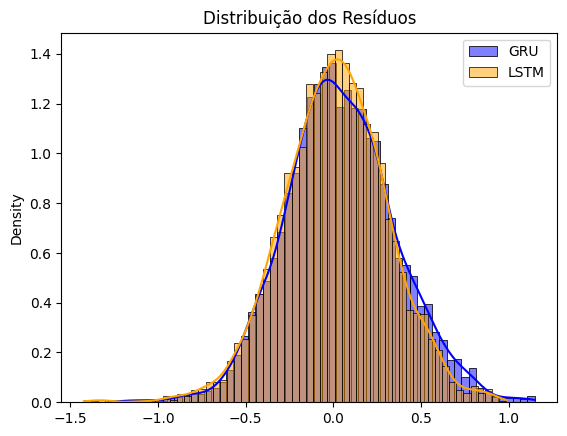

In [33]:
import seaborn as sns
sns.histplot(gru_residuals, kde=True, color='blue', label='GRU', stat='density')
sns.histplot(lstm_residuals, kde=True, color='orange', label='LSTM', stat='density')
plt.legend()
plt.title("Distribuição dos Resíduos")
plt.show()


Eles seguem uma distribuição normal como esperado

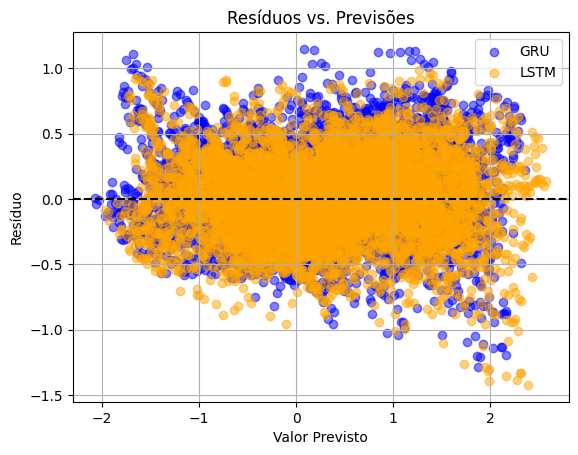

In [34]:
plt.scatter(y_pred_seq_gru, gru_residuals, alpha=0.5, label='GRU', color='blue')
plt.scatter(y_pred_seq_lstm, lstm_residuals, alpha=0.5, label='LSTM', color='orange')
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos vs. Previsões")
plt.xlabel("Valor Previsto")
plt.ylabel("Resíduo")
plt.legend()
plt.grid(True)
plt.show()


Nenhuma heterocedasticidade possivel de ser visualizada nesse gráfico

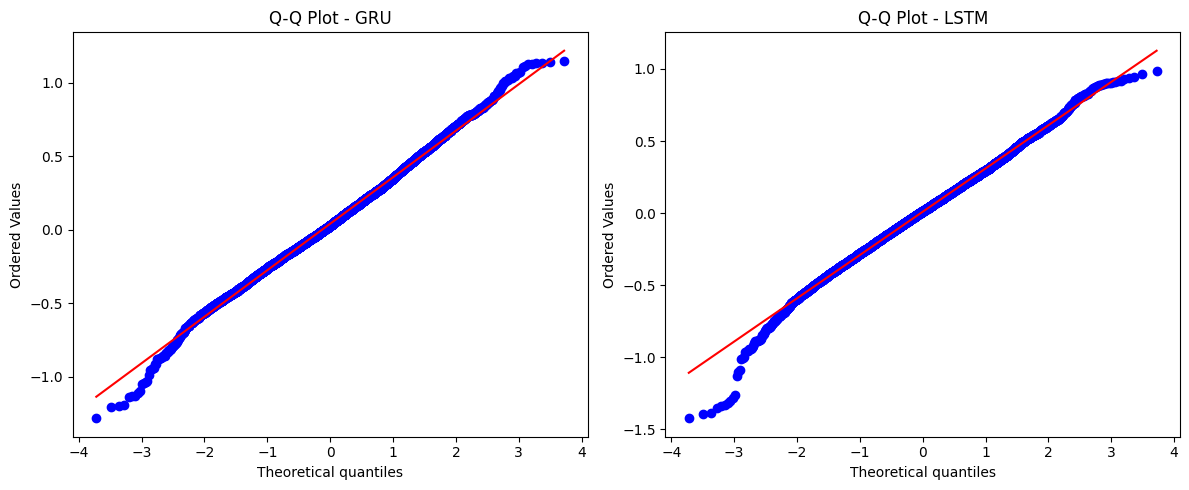

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# Q-Q Plots without statsmodels
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# GRU Q-Q Plot
probplot(gru_residuals, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot - GRU")

# LSTM Q-Q Plot
probplot(lstm_residuals, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot - LSTM")

plt.tight_layout()
plt.show()


## 6. Discussão e Conclusão

Ambos os modelos **LSTM** e **GRU** demonstraram boa capacidade de prever a temperatura horária com até 24 horas de antecedência.

O **GRU apresentou desempenho ligeiramente superior**, o que pode ser explicado por sua **arquitetura mais simples e eficiente**, sendo menos propenso ao overfitting em conjuntos de dados de tamanho moderado.

Dado o **custo computacional menor** do GRU e sua **performance competitiva**, ele é o modelo mais indicado neste cenário.
